Imports

In [4]:
import itertools
import time

import numpy as np
import pandas as pd

from copy import deepcopy

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

from matplotlib import pyplot as plt

Neural Network

In [5]:
def cross_entropy_loss(reference_Y, predicted_Y):
    
    loss = 0
    m = reference_Y.shape[0]
    
    for yt, yp in zip(reference_Y, predicted_Y):
        
        value = -1 * np.sum(yt * np.log(yp) + (1 - yt) * np.log(1 - yp))
        
        loss += value
    
    loss = (1 / m) * loss
    
    return loss


class NeuralNetwork:
    
    def __init__(self,
                 input_nodes,
                 first_hidden_nodes,
                 second_hidden_nodes,
                 output_nodes,
                 learning_rate,
                 hidden_activation_function,
                 hidden_activation_derivative):
        
        self.input_nodes = input_nodes
        self.first_hidden_nodes = first_hidden_nodes
        self.second_hidden_nodes = second_hidden_nodes
        self.output_nodes = output_nodes
        
        self.learning_rate = learning_rate
        
        self.bwih = np.random.uniform(-0.1, 0.1, self.first_hidden_nodes).reshape(self.first_hidden_nodes, 1)
        self.bwhh = np.random.uniform(-0.1, 0.1, self.second_hidden_nodes).reshape(self.second_hidden_nodes, 1)
        self.bwho = np.random.uniform(-0.1, 0.1, self.output_nodes).reshape(self.output_nodes, 1)
        
        self.wih = np.random.uniform(-0.1, 0.1, self.first_hidden_nodes * self.input_nodes).reshape(self.first_hidden_nodes, self.input_nodes)
        self.whh = np.random.uniform(-0.1, 0.1, self.second_hidden_nodes * self.first_hidden_nodes).reshape(self.second_hidden_nodes, self.first_hidden_nodes)
        
        hidden_nodes = self.first_hidden_nodes if (self.second_hidden_nodes == 0) else self.second_hidden_nodes
        
        self.who = np.random.uniform(-0.1, 0.1, self.output_nodes * hidden_nodes).reshape(self.output_nodes, hidden_nodes)
        
        self.hidden_activation_function = hidden_activation_function
        self.hidden_activation_derivative = hidden_activation_derivative
    
    def _softmax(self, x):
        
        value = np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x))) 
        return value
    
    def partial_fit(self, X, y):
        
        for inputs, targets in zip(X_normalized_training, y_normalized_training):

            self._train(inputs, targets)
    
    def _train(self, inputs, targets):
        
        if (self.second_hidden_nodes == 0):
            
            self._one_hidden_layer_train(inputs, targets)
            
        else:
            
            self._two_hidden_layer_train(inputs, targets)
        
    
    def _one_hidden_layer_train(self, inputs, targets):
        
        inputs = np.array(inputs, ndmin = 2).T
        targets = np.array(targets, ndmin = 2).T
                

        hidden_inputs = np.dot(self.wih, inputs) + (self.bwih * 1)
        hidden_outputs = self.hidden_activation_function(hidden_inputs)
        
        final_inputs = np.dot(self.who, hidden_outputs) + (self.bwho * 1)
        outputs = self._softmax(final_inputs)
        
        output_errors = targets - outputs
        
        self.bwho += self.learning_rate * output_errors
        self.who += self.learning_rate * np.dot(output_errors, hidden_outputs.T)
                
        hidden_errors = np.dot(self.who.T, output_errors)
        
        self.bwih += self.learning_rate * (hidden_errors * self.hidden_activation_derivative(hidden_inputs))        
        self.wih += self.learning_rate * np.dot((hidden_errors * self.hidden_activation_derivative(hidden_inputs)), inputs.T)
        
    
    def _two_hidden_layer_train(self, inputs, targets):
        
        inputs = np.array(inputs, ndmin = 2).T
        targets = np.array(targets, ndmin = 2).T
        
        first_hidden_inputs = np.dot(self.wih, inputs) + (self.bwih * 1)
        first_hidden_outputs = self.hidden_activation_function(first_hidden_inputs)
        
        second_hidden_inputs = np.dot(self.whh, first_hidden_outputs) + (self.bwhh * 1)
        second_hidden_outputs = self.hidden_activation_function(second_hidden_inputs)
        
        final_inputs = np.dot(self.who, second_hidden_outputs) + (self.bwho * 1)
        outputs  = self._softmax(final_inputs)
        
        output_errors = targets - outputs
        
        self.bwho += self.learning_rate * output_errors
        self.who += self.learning_rate * np.dot(output_errors, second_hidden_outputs.T)
        
        second_hidden_errors = np.dot(self.who.T, output_errors)
        
        self.bwhh += self.learning_rate * (second_hidden_errors * self.hidden_activation_derivative(second_hidden_inputs))
        self.whh += self.learning_rate * np.dot((second_hidden_errors * self.hidden_activation_derivative(second_hidden_inputs)), first_hidden_outputs.T)
        
        first_hidden_errors = np.dot(self.whh.T, second_hidden_errors)
        
        self.bwih += self.learning_rate * (first_hidden_errors * self.hidden_activation_derivative(first_hidden_inputs))
        self.wih += self.learning_rate * np.dot((first_hidden_errors * self.hidden_activation_derivative(first_hidden_inputs)), inputs.T)
    
    def predict(self, X):
        
        outputs = []
        
        for inputs in X:
            
            output = self._query(inputs)
            
            output = np.argmax(output)
            
            outputs.append(output)
            
        outputs = np.array(outputs)
        
        return outputs
    
    def predict_proba(self, X):
        
        outputs = []
        
        for inputs in X:
            
            output = self._query(inputs)
            
            outputs.append(output)
            
        outputs = np.array(outputs)
        
        return outputs
        
    
    def _query(self, inputs):
        
        result = np.array([])
        
        if (self.second_hidden_nodes == 0):
            
            result = self._one_hidden_layer_query(inputs)
        
        else:
            
            result = self._two_hidden_layer_query(inputs)
    
        return result
    
    def _one_hidden_layer_query(self, inputs):
        
        inputs = np.array(inputs, ndmin = 2).T
        
        hidden_inputs = np.dot(self.wih, inputs) + (self.bwih * 1)
        hidden_outputs = self.hidden_activation_function(hidden_inputs)
        
        final_inputs = np.dot(self.who, hidden_outputs) + (self.bwho * 1)
        final_outputs  = self._softmax(final_inputs)
        
        return final_outputs.ravel()
    
    def _two_hidden_layer_query(self, inputs):
        
        inputs = np.array(inputs, ndmin = 2).T
        
        first_hidden_inputs = np.dot(self.wih, inputs) + (self.bwih * 1)
        first_hidden_outputs = self.hidden_activation_function(first_hidden_inputs)
        
        second_hidden_inputs = np.dot(self.whh, first_hidden_outputs) + (self.bwhh * 1)
        second_hidden_outputs = self.hidden_activation_function(second_hidden_inputs)
        
        final_inputs = np.dot(self.who, second_hidden_outputs) + (self.bwho * 1)
        final_outputs  = self._softmax(final_inputs)
        
        return final_outputs.ravel()

Read Training Data

In [6]:
training_set = pd.read_csv('fashion-mnist_train.csv', sep = ',')

Split Features and Labels

In [7]:
X_train, y_train = training_set.iloc[:, 1:].values, training_set.iloc[:, 0].values

Split Test and Validation

In [8]:
training_percentage = 0.8

training_size = round(X_train.shape[0] * 0.8)

X_training = X_train[:training_size]
X_validation = X_train[training_size:]

y_training = y_train[:training_size]
y_validation = y_train[training_size:]

Normalize Data

In [9]:
# An grayscale image must have 255 as maximum value
maximum_value = 255 

# Executes normalization between 0.01 and 0.99
X_normalized_training = (X_training / maximum_value * 0.99) + 0.01
X_normalized_validation = (X_validation / maximum_value * 0.99) + 0.01

# Executes one-hot-encoding on labels
y_normalized_training = pd.get_dummies(y_training).values
y_normalized_validation = pd.get_dummies(y_validation).values

Training model with early stoping

In [23]:
epochs = 60
learning_rate = 0.001

input_nodes = 784
first_hidden_nodes = 15
second_hidden_nodes = 0
output_nodes = 10

hidden_activation_function = lambda x : 1 / (1 + np.exp(-x))
hidden_activation_derivative = lambda x : hidden_activation_function(x) * (1 - hidden_activation_function(x))

n = NeuralNetwork(input_nodes,
                  first_hidden_nodes,
                  second_hidden_nodes,
                  output_nodes,
                  learning_rate,
                  hidden_activation_function,
                  hidden_activation_derivative)

total_start = time.time()

selected = float("Inf")

best_model = None
best_epoch = 0

training_epochs = []
validation_epochs = []

for epoch in range(epochs):
    
    start = time.time()
    
    training_losses = []
    validation_losses = []
    
    n.partial_fit(X_normalized_training, y_normalized_training)
    
    predicted_training_y = n.predict_proba(X_normalized_training)
    predicted_validation_y = n.predict_proba(X_normalized_validation)
    
    training_loss = cross_entropy_loss(y_normalized_training, predicted_training_y)
    validation_loss = cross_entropy_loss(y_normalized_validation, predicted_validation_y)
    
    training_epochs.append([epoch + 1, training_loss])
    validation_epochs.append([epoch + 1, validation_loss])
    
    # Early Stopping
    if(validation_loss < selected):
        
        selected = validation_loss        
        best_model = deepcopy(n)
        best_epoch = epoch
        
    finish = time.time()
    
    print("Epoch: " + str(epoch + 1) + " Training Loss: " + str(training_loss) + " Validation Loss: " + str(validation_loss) + " Time: " + str((finish - start)) + "s")
    
total_finish = time.time()

print("Elapsed Time: " + str((total_finish - total_start) / 60) + "mins")

Epoch: 1 Training Loss: 1.796463590331225 Validation Loss: 1.7963247943018692 Time: 8.410489082336426s
Epoch: 2 Training Loss: 1.3258901478422778 Validation Loss: 1.3301034255182698 Time: 8.189510822296143s
Epoch: 3 Training Loss: 1.1157171682362823 Validation Loss: 1.1257290355253886 Time: 8.234277725219727s
Epoch: 4 Training Loss: 0.9983163646622214 Validation Loss: 1.0132547970120502 Time: 8.208562850952148s
Epoch: 5 Training Loss: 0.9252336120243102 Validation Loss: 0.9437450126703925 Time: 8.088985681533813s
Epoch: 6 Training Loss: 0.875886518955769 Validation Loss: 0.8971485080383957 Time: 8.202839136123657s
Epoch: 7 Training Loss: 0.8397215445838727 Validation Loss: 0.863460833415587 Time: 8.23390245437622s
Epoch: 8 Training Loss: 0.811672558130194 Validation Loss: 0.8378107950550111 Time: 8.224552869796753s
Epoch: 9 Training Loss: 0.7891427504341444 Validation Loss: 0.8176017170275166 Time: 8.165979146957397s
Epoch: 10 Training Loss: 0.7705923969745105 Validation Loss: 0.801262

Plot Loss

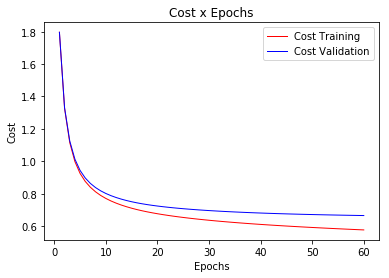

In [42]:
training_df = pd.DataFrame(data = training_epochs, columns = ['Epoch', 'Cost'])
validation_df = pd.DataFrame(data = validation_epochs, columns = ['Epoch', 'Cost'])

plt.plot(training_df['Epoch'], training_df['Cost'], linewidth = 1.0, color = 'red')
plt.plot(validation_df['Epoch'], validation_df['Cost'], linewidth = 1.0, color = 'blue')

plt.xlabel('Epochs')
plt.ylabel('Cost')

plt.title("Cost x Epochs")
plt.legend(['Cost Training', 'Cost Validation'])

plt.show()

Acurácia na Validação

In [43]:
y_predicted = best_model.predict(X_normalized_validation)
accuracy = accuracy_score(y_validation, y_predicted)
print("Accuracy: " + str(accuracy))

Accuracy: 0.866


Read Test Data

In [44]:
test_set = pd.read_csv('fashion-mnist_test.csv', sep = ',')

Split Features and Labels

In [45]:
X_test, y_test = test_set.iloc[:, 1:].values, test_set.iloc[:, 0].values

Normalize Data

In [46]:
# An grayscale image must have 255 as maximum value
maximum_value = 255 

# Executes normalization between 0.01 and 0.99
X_normalized_test = (X_test / maximum_value * 0.99) + 0.01

Predicting values from test set

In [47]:
y_predicted = best_model.predict(X_normalized_test)
accuracy = accuracy_score(y_test, y_predicted)
accuracy

0.8715

Plot Confusion Matrix - Definitions

In [48]:
def plot_confusion_matrix(confusion_matrix, classes, normalize = False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    
    thresh = confusion_matrix.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, 
                 i, 
                 format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color = "black")#"white" if cm[i, j] > thresh else "black"

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def extract_metrics(confusion_matrix):
    
    true_positive = np.diagonal(confusion_matrix)
    
    false_negative = np.sum(confusion_matrix, axis = 1) - np.diagonal(cm)
    
    false_positive = np.sum(confusion_matrix, axis = 0) - np.diagonal(cm)
    
    true_negative = np.array([np.sum(confusion_matrix) - np.sum(confusion_matrix, axis = 0)[i] - np.sum(confusion_matrix, axis = 1)[i] for i in range(confusion_matrix.shape[0])])
    
    return true_positive, false_negative, false_positive, true_negative 
    
classes = np.unique(y_test)
cm = confusion_matrix(y_test, y_predicted)
ncm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [49]:
cm

array([[834,   3,  15,  32,   0,   3,  97,   0,  14,   2],
       [  2, 973,   2,  15,   2,   1,   5,   0,   0,   0],
       [ 16,   1, 778,   8,  97,   0,  96,   0,   4,   0],
       [ 31,  19,  11, 892,  24,   0,  22,   0,   1,   0],
       [  1,   0,  70,  31, 811,   0,  83,   0,   4,   0],
       [  1,   0,   0,   1,   0, 924,   1,  39,   6,  28],
       [146,   2,  62,  26,  66,   2, 678,   0,  18,   0],
       [  0,   0,   0,   0,   0,  34,   0, 904,   1,  61],
       [  3,   0,   5,   6,   5,   3,  17,   4, 955,   2],
       [  0,   0,   0,   0,   0,  10,   0,  23,   1, 966]], dtype=int64)

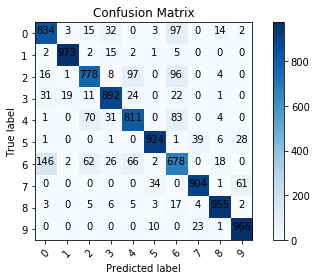

In [50]:
plot_confusion_matrix(cm, classes, title = "Confusion Matrix")

In [51]:
true_positive, false_negative, false_positive, true_negative = extract_metrics(cm)

In [52]:
# Entre os valores classificados como positivos, qual a porcentagem dos que realmente eram positivos
class_precision = true_positive / (true_positive + false_positive)

class_precision_data = np.stack((classes, class_precision), axis = 1)

pd.DataFrame(data = class_precision_data, columns = ['Class', 'Precision'])

,Class,Precision
0,0.0,0.806576
1,1.0,0.974950
2,2.0,0.825027
3,3.0,0.882295
4,4.0,0.806965
5,5.0,0.945752
6,6.0,0.678679
7,7.0,0.931959
8,8.0,0.951195
9,9.0,0.912181


In [53]:
# Entre os valores que deveriam ser positivos, qual o porcentagem dos que foram classificados como positivos
class_recall = true_positive / (true_positive + false_negative)

class_recall_data = np.stack((classes, class_recall), axis = 1)

pd.DataFrame(data = class_recall_data, columns = ['Class', 'Recall'])

,Class,Recall
0,0.0,0.834
1,1.0,0.973
2,2.0,0.778
3,3.0,0.892
4,4.0,0.811
5,5.0,0.924
6,6.0,0.678
7,7.0,0.904
8,8.0,0.955
9,9.0,0.966


In [54]:
class_f1_score = 2 * class_precision * class_recall / (class_precision + class_recall)

class_f1_score_data = np.stack((classes, class_f1_score), axis = 1)

pd.DataFrame(data = class_f1_score_data, columns = ['Class', 'F1 Score'])

,Class,F1 Score
0,0.0,0.820059
1,1.0,0.973974
2,2.0,0.800823
3,3.0,0.887121
4,4.0,0.808978
5,5.0,0.934750
6,6.0,0.678339
7,7.0,0.917766
8,8.0,0.953094
9,9.0,0.938320


In [55]:
model_accuracy = np.diagonal(cm).sum() / np.sum(cm)
model_accuracy

0.8715

In [56]:
# Normalized Accuracy = Precision
model_normalized_accuracy = np.sum(true_positive / (true_positive + false_positive)) / 10
model_normalized_accuracy

0.8715579011823589

In [57]:
model_precision = np.sum(class_precision) / 10
model_precision

0.8715579011823589

In [58]:
model_recall = np.sum(class_recall) / 10
model_recall

0.8714999999999999

In [59]:
model_f1_score = np.sum(class_f1_score) / 10
model_f1_score

0.8713223504069063